In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

This notebook shows different ways to visualize the data from the model comparison.
To see the results for other microphone positions change the path used for raw_data.

In [2]:
raw_data = pd.read_csv("raw/results_raw_outside.csv")

In [3]:
# To get the name of a model we use modelnames[model_id]
modelnames = ["kNN", "Linear", "3 Layer FC", "4 Layer FC", "5 Layer FC", "1-Channel CNN", "2-Channel CNN", "3-Channel CNN", "4-Channel CNN"]

In [4]:
# Different metrics to compare models. New metrics can be implemented in the same fashion
raw_data["q0_error"] = np.rad2deg(raw_data.true_q0 - raw_data.pred_q0)
raw_data["q3_error"] = np.rad2deg(raw_data.true_q3 - raw_data.pred_q3)
raw_data["abs_q0_error"] = np.abs(raw_data.q0_error)
raw_data["abs_q3_error"] = np.abs(raw_data.q3_error)
raw_data["error"] = 0.5*(raw_data.abs_q0_error + raw_data.abs_q3_error)
raw_data["norm_error"] = np.sqrt(raw_data.q0_error**2 + raw_data.q3_error**2)

In [5]:
tabledata = pd.pivot_table(raw_data, index='model_id', values=["error", "abs_q0_error", "abs_q3_error"], aggfunc="mean") 

In [6]:
tabledata

,abs_q0_error,abs_q3_error,error
model_id,,,
0,10.555768,15.181467,12.868617
1,13.538015,12.648634,13.093324
2,8.012722,9.061784,8.537253
3,8.166657,9.385429,8.776043
4,8.763187,9.928934,9.346061
5,6.665648,9.673911,8.169779
6,5.344792,7.627163,6.485978
7,4.330876,6.897124,5.614000
8,3.725321,6.416005,5.070663


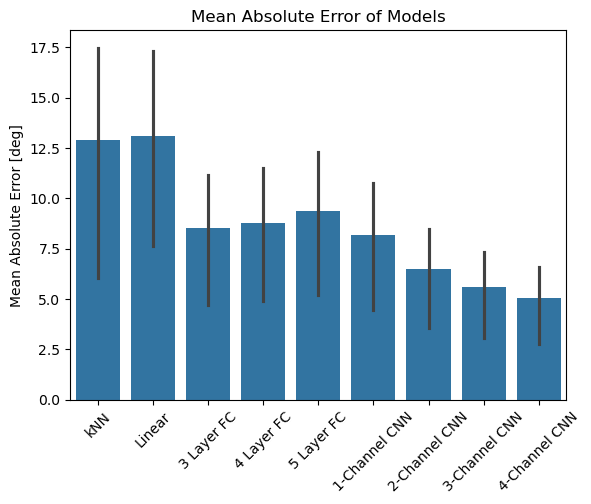

In [7]:
ax = sns.barplot(data=raw_data, x="model_id", y="error", errorbar=("pi", 50))
plt.xticks(rotation=45)
plt.ylabel("Mean Absolute Error [deg]")
plt.xlabel("")
plt.title("Mean Absolute Error of Models")
plt.gca().xaxis.set_major_formatter(lambda x,_: modelnames[int(x)])

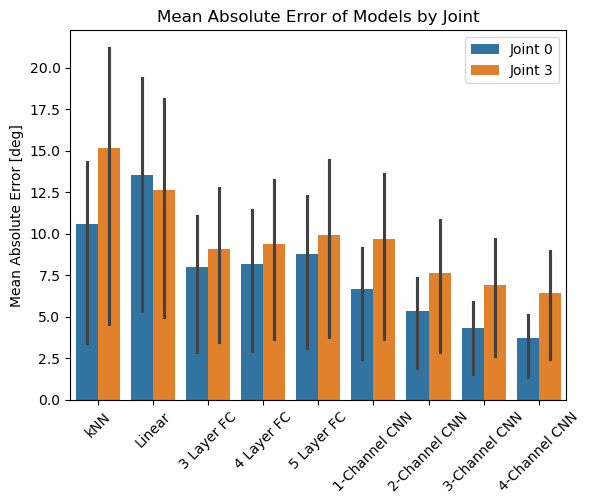

In [8]:
# to split the error aling the joint we transform the table into longform data, which is the format seaborn expects
error_longform = raw_data.rename(columns={"abs_q0_error": "Joint 0", "abs_q3_error": "Joint 3"}).melt(id_vars="model_id", value_vars=["Joint 0", "Joint 3"])
ax = sns.barplot(data=error_longform, x="model_id", y="value", hue="variable", errorbar=("pi",50))
plt.xticks(rotation=45)
plt.ylabel("Mean Absolute Error [deg]")
plt.xlabel("")
plt.title("Mean Absolute Error of Models by Joint")
plt.gca().xaxis.set_major_formatter(lambda x,_: modelnames[int(x)])
L=plt.legend()
L.get_texts()[0] = "Joint 0"
L.get_texts()[1] = "Joint 3"

(0.0, 15.9)

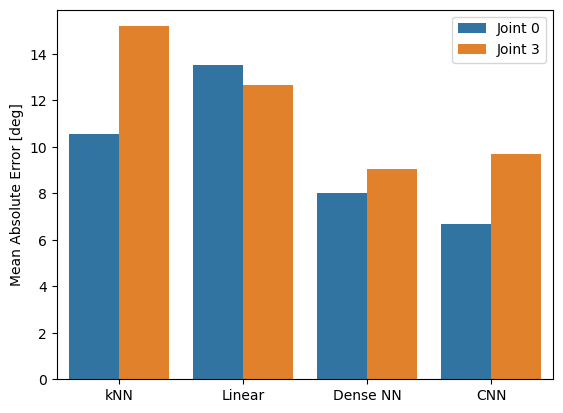

In [9]:
# We can select a subset of the models by id
model_subset = [0,1,2,5]
subset_names = ["kNN", "Linear", "Dense NN", "CNN"]
ax = sns.barplot(data=error_longform.loc[error_longform.model_id.isin(model_subset)], x="model_id", y="value", hue="variable", errorbar=None)#("pi", 50))
plt.ylabel("Mean Absolute Error [deg]")
plt.xlabel("")
#plt.title("Mean Absolute Error of Models per Joint")
plt.gca().xaxis.set_major_formatter(lambda _,pos: subset_names[int(pos)])
plt.legend()
plt.ylim(0,15.9)
#plt.gcf().set_dpi(500)

We want to consider the data with the true q_0 value as prior. Since we get floating point errors during data collection, we need to clean those values.

In [10]:
raw_data["cleaned_q0"] = np.round(raw_data.true_q0, 2)
# Change model_id to inspect predictions of other models
avg_preds = pd.pivot_table(raw_data.loc[raw_data.model_id == 5], values = ["pred_q0","pred_q3", "error"], index=["cleaned_q0", "true_q3"], aggfunc="mean")

/tmp/ipykernel_9794/300469561.py:17: RuntimeWarning: invalid value encountered in sqrt
  c = np.sqrt((+1.5708)/0.1 - 32* (+0.2)/0.1)


(-170.0, -10.0)

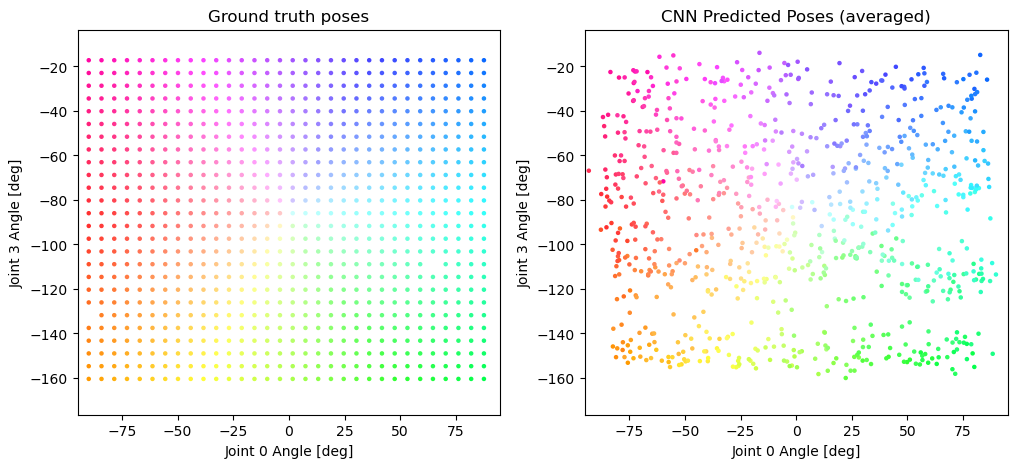

In [11]:
import matplotlib.colors as mcol

# color datapoints by their ground truth position in a color-wheel fashion.
# to obtain those colors we need polar coordinates

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def to_unit(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

mag, angle = cart2pol(avg_preds.index.get_level_values(0).to_numpy(), avg_preds.index.get_level_values(1).to_numpy() + 1.5)

colors = mcol.hsv_to_rgb(np.hstack([to_unit(angle)[:,None], to_unit(mag)[:,None]*0.8+0.2, np.ones_like(angle)[:,None]]))
c = np.sqrt((+1.5708)/0.1 - 32* (+0.2)/0.1)


fig, axs = plt.subplots(1,2, figsize=(12,5))

axs[0].scatter(np.rad2deg(avg_preds.index.get_level_values(0)), np.rad2deg(avg_preds.index.get_level_values(1)), s=5, c=colors)
axs[1].scatter(np.rad2deg(avg_preds.pred_q0), np.rad2deg(avg_preds.pred_q3), c=colors, s=5)#, marker="x")
axs[0].axis("equal")
axs[1].axis("equal")
axs[0].set_ylabel("Joint 3 Angle [deg]")
axs[1].set_ylabel("Joint 3 Angle [deg]")
axs[0].set_xlabel("Joint 0 Angle [deg]")
axs[1].set_xlabel("Joint 0 Angle [deg]")
axs[0].set_title("Ground truth poses")
axs[1].set_title("CNN Predicted Poses (averaged)")
axs[1].set_xlim(-95,95)
axs[1].set_ylim(-170, -10)
axs[0].set_xlim(-95,95)
axs[0].set_ylim(-170, -10)
# plt.colorbar()

Text(0.5, 1.0, ' predictions of CNN for position (0, -1.5)')

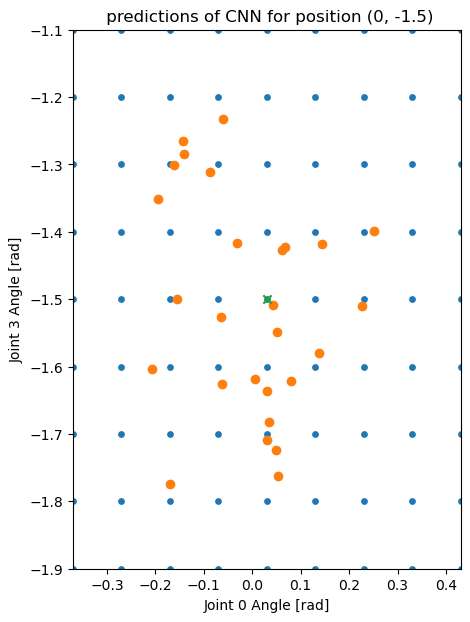

In [12]:
# visualize predictions of a specific data point (eg center)

one_pos = raw_data.loc[(raw_data.model_id == 5) & (raw_data.cleaned_q0 == 0.03) & (raw_data.true_q3 == -1.5)]

fig, ax = plt.subplots(figsize=(5,7))
lin = np.arange(-5,5) * 0.1
xx, yy = np.meshgrid(lin + 0.03, lin-1.5)
plt.scatter(xx, yy, s=15)
plt.scatter(one_pos.pred_q0, one_pos.pred_q3)
plt.scatter([0.03], [-1.5], marker="x")

plt.xlim(-0.37, 0.43)
plt.ylim(-1.9, -1.1)
plt.xlabel("Joint 0 Angle [rad]")
plt.ylabel("Joint 3 Angle [rad]")
plt.title(" predictions of CNN for position (0, -1.5)")

In [13]:
# KDE plot to roughly visualize one standard deviation

import scipy.stats as st

xmin = ymin = -30
xmax = ymax = 30

x = raw_data.loc[raw_data.model_id == 5, "q0_error"]
y = raw_data.loc[raw_data.model_id == 5, "q3_error"]

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

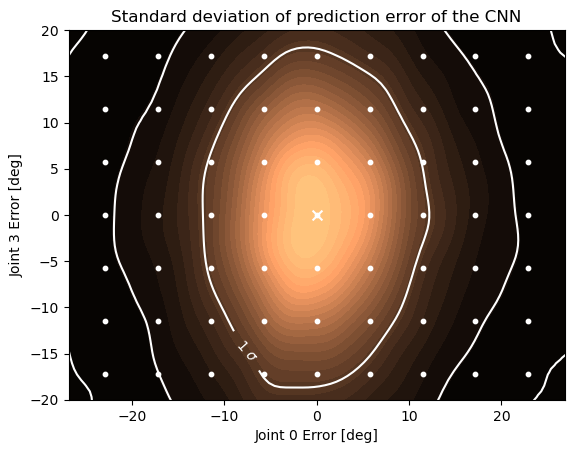

In [14]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, np.linspace(0,np.max(f),25),cmap='copper')

isoprop = np.array([1-0.9973,1-0.9545,1 - 0.6827])
values = np.ravel(f)
sorted_values = np.sort(values)[::-1]
normalized_values = np.cumsum(sorted_values) / values.sum()
idx = np.searchsorted(normalized_values, 1 - isoprop)
levels = np.take(sorted_values, idx, mode="clip")

cset = ax.contour(xx, yy, f, levels, colors='white')
# Label plot
L = ax.clabel(cset, [cset.levels[-1]], fmt=lambda _: r"1 $\sigma$", inline=1, fontsize=10)

samplepoints = np.rad2deg(np.arange(20) * 0.1 -1)
sctrx, sctry = np.meshgrid(samplepoints, samplepoints)
ax.scatter(sctrx, sctry, c="white",s=10)
ax.scatter([0],[0], marker="x", c="white", s=50)
ax.set_xlabel('Joint 0 Error [deg]')
ax.set_ylabel('Joint 3 Error [deg]')
plt.axis("equal")
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
plt.title("Standard deviation of prediction error of the CNN")
plt.show()

Text(0.5, 0.92, 'Distribution of the prediction error of the CNN')

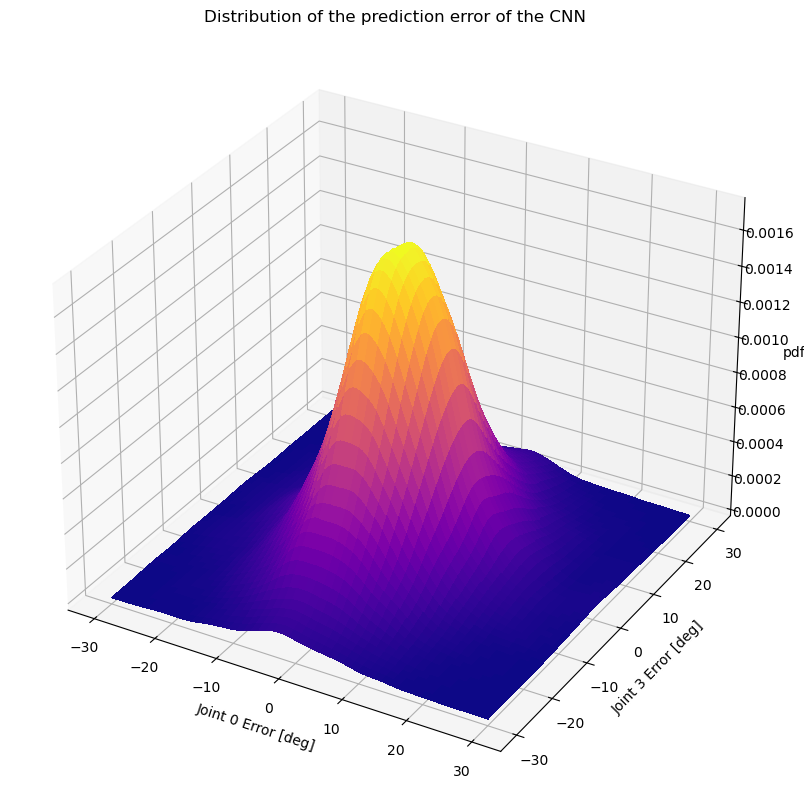

In [15]:
# The same KDE as a 3d plot

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(xx,yy, f, cmap="plasma",linewidth=0, antialiased=False)#, vmin = -2, vmax=2)

ax.set_xlabel('Joint 0 Error [deg]')
ax.set_ylabel('Joint 3 Error [deg]')
ax.set_zlabel('pdf')
ax.set_title('Distribution of the prediction error of the CNN')

In [16]:
print("modelname     std q0  std q3")
for i in range(len(modelnames)):
    name = modelnames[i]
    q0_std = np.std(raw_data.loc[raw_data.model_id == i, "q0_error"])
    q3_std = np.std(raw_data.loc[raw_data.model_id == i, "q3_error"])
    print(f"{name:13}  {q0_std: >5.2f}   {q3_std: >5.2f}")

modelname     std q0  std q3
kNN            14.74   19.00
Linear         17.16   16.09
3 Layer FC     10.87   11.69
4 Layer FC     11.01   12.05
5 Layer FC     11.72   12.71
1-Channel CNN   9.05   12.62
2-Channel CNN   7.52    9.95
3-Channel CNN   6.29    9.09
4-Channel CNN   5.29    8.51


Text(0.5, 0.98, 'Histogram of errors for selected Models')

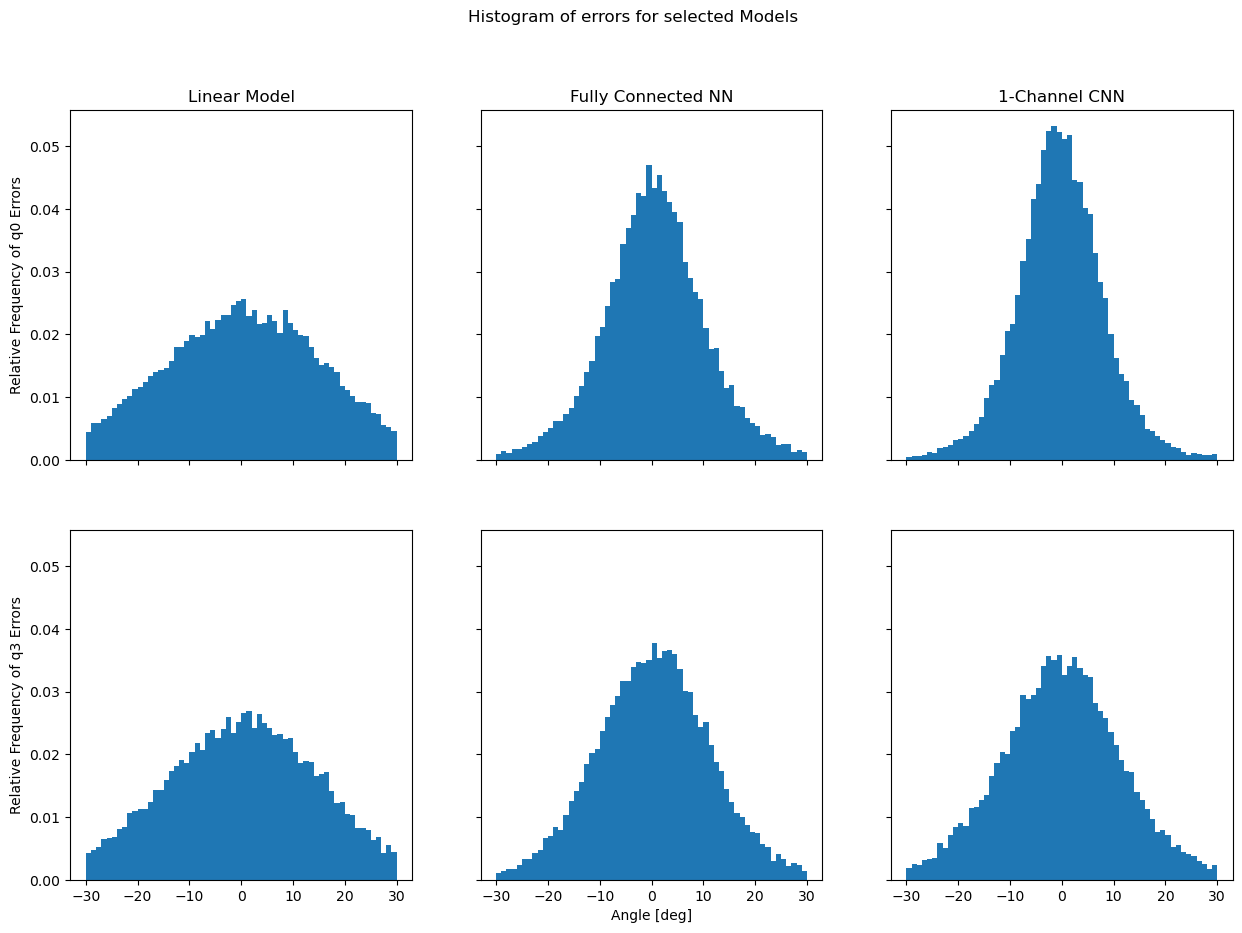

In [17]:
# Error visualized as a histogram

datapoints = np.sum(raw_data.model_id == 0)
fig, axs = plt.subplots(2,3, sharex=True, sharey=True, figsize=(15,10))
axs[0,0].hist(x=raw_data.loc[raw_data.model_id==1, "q0_error"], bins=60, range=(-30,30), weights=np.ones(datapoints) / datapoints)
axs[0,0].set_ylabel("Relative Frequency of q0 Errors")
axs[0,0].set_title("Linear Model")
axs[0,1].hist(x=raw_data.loc[raw_data.model_id==2, "q0_error"], bins=60, range=(-30,30), weights=np.ones(datapoints) / datapoints)
axs[0,1].set_title("Fully Connected NN")
axs[0,2].hist(x=raw_data.loc[raw_data.model_id==5, "q0_error"], bins=60, range=(-30,30), weights=np.ones(datapoints) / datapoints)
axs[0,2].set_title("1-Channel CNN")
axs[1,0].hist(x=raw_data.loc[raw_data.model_id==1, "q3_error"], bins=60, range=(-30,30), weights=np.ones(datapoints) / datapoints)
axs[1,0].set_ylabel("Relative Frequency of q3 Errors")
axs[1,1].hist(x=raw_data.loc[raw_data.model_id==2, "q3_error"], bins=60, range=(-30,30), weights=np.ones(datapoints) / datapoints)
axs[1,1].set_xlabel("Angle [deg]")
axs[1,2].hist(x=raw_data.loc[raw_data.model_id==5, "q3_error"], bins=60, range=(-30,30), weights=np.ones(datapoints) / datapoints)
fig.suptitle("Histogram of errors for selected Models")

In [18]:
pivot_q0 = pd.pivot_table(raw_data, columns="model_id", values = ["pred_q0","abs_q0_error","abs_q3_error","error"], index="cleaned_q0", aggfunc="mean")

(-1.725, 1.685, -1.65, 1.65)

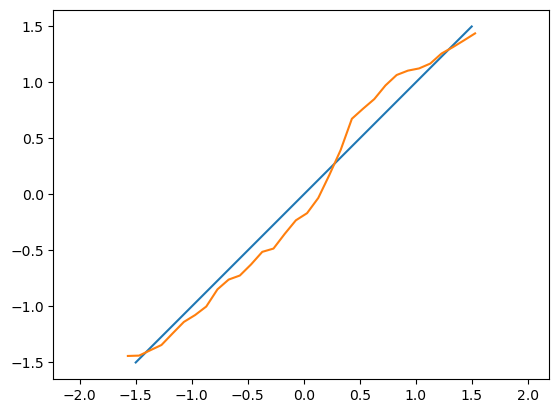

In [19]:
# Average prediction based on true q0

plt.plot((-1.5,1.5), (-1.5,1.5))
plt.plot(pivot_q0.index, pivot_q0[("pred_q0", 0)])
plt.axis("equal")

Text(0.5, 1.0, 'Error of different models')

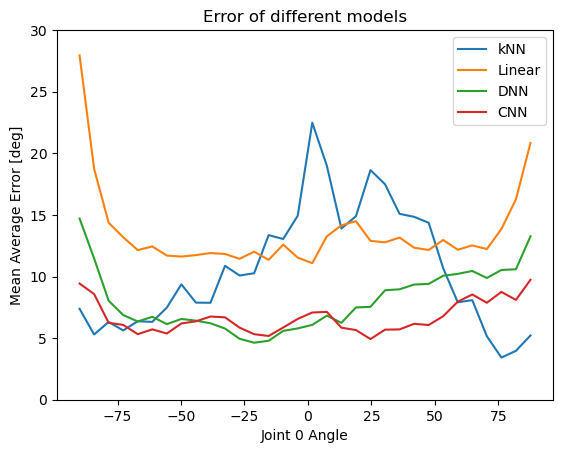

In [20]:
plt.plot(np.rad2deg(pivot_q0.index), pivot_q0[("abs_q0_error", 0)], label="kNN")
plt.plot(np.rad2deg(pivot_q0.index), pivot_q0[("abs_q0_error", 1)], label="Linear")
plt.plot(np.rad2deg(pivot_q0.index), pivot_q0[("abs_q0_error", 2)], label="DNN")
plt.plot(np.rad2deg(pivot_q0.index), pivot_q0[("abs_q0_error", 5)], label="CNN")
plt.legend()
plt.ylim(0,30)
plt.ylabel("Mean Average Error [deg]")
plt.xlabel("Joint 0 Angle")
plt.title("Error of different models")

Text(0.5, 1.0, 'CNN Error')

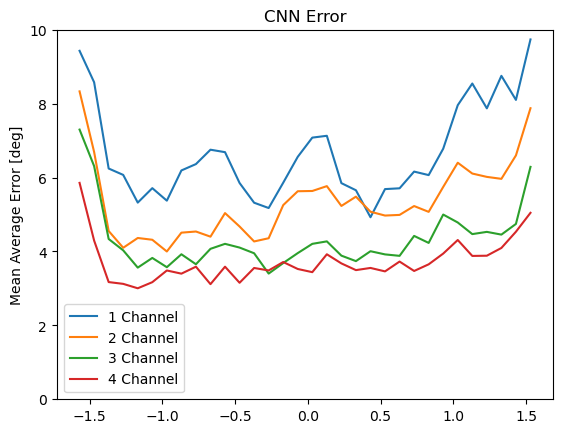

In [21]:
plt.plot(pivot_q0.index, pivot_q0[("abs_q0_error", 5)], label="1 Channel")
plt.plot(pivot_q0.index, pivot_q0[("abs_q0_error", 6)], label="2 Channel")
plt.plot(pivot_q0.index, pivot_q0[("abs_q0_error", 7)], label="3 Channel")
plt.plot(pivot_q0.index, pivot_q0[("abs_q0_error", 8)], label="4 Channel")
plt.ylabel("Mean Average Error [deg]")
plt.legend()
plt.ylim(0,10)
plt.title("CNN Error")

In [22]:
pivot_q3 = pd.pivot_table(raw_data, columns="model_id", values = ["pred_q0","abs_q0_error","abs_q3_error","error"], index="true_q3", aggfunc="mean")

Text(0.5, 1.0, 'Error of different models')

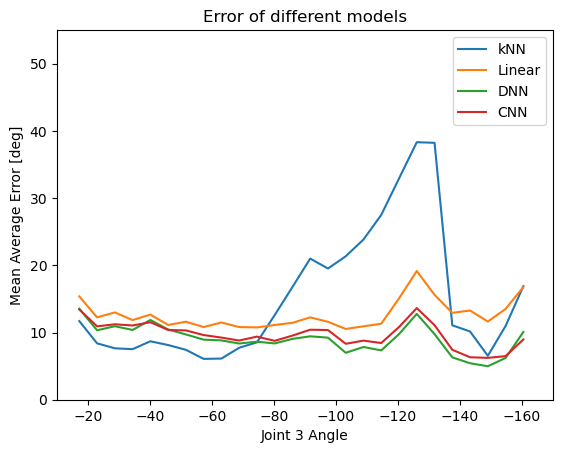

In [23]:
plt.plot(np.rad2deg(pivot_q3.index), pivot_q3[("abs_q3_error", 0)], label="kNN")
plt.plot(np.rad2deg(pivot_q3.index), pivot_q3[("abs_q3_error", 1)], label="Linear")
plt.plot(np.rad2deg(pivot_q3.index), pivot_q3[("abs_q3_error", 2)], label="DNN")
plt.plot(np.rad2deg(pivot_q3.index), pivot_q3[("abs_q3_error", 5)], label="CNN")
plt.legend()
plt.ylim(0,55)
plt.ylabel("Mean Average Error [deg]")
plt.xlabel("Joint 3 Angle")
plt.xlim(-10,-170)
plt.title("Error of different models")

Text(0.5, 0.98, 'Errors of predicting Jointangles for different Models')

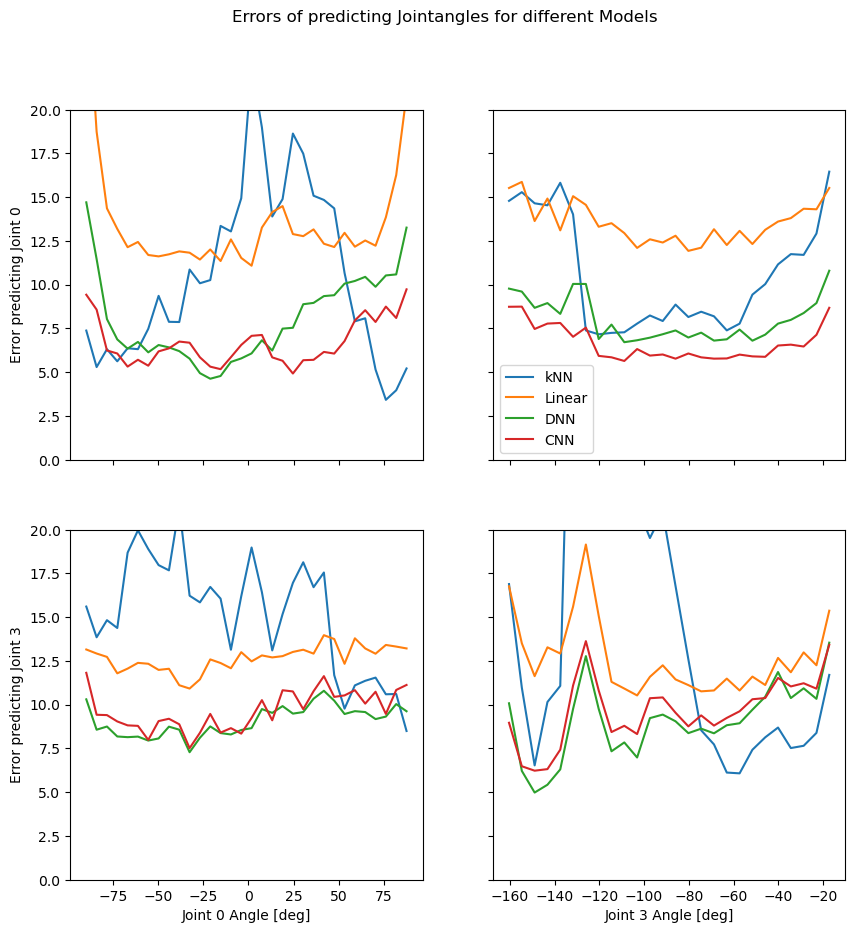

In [24]:
# Display all four combinations (Error of joint {0, 3} based on joint {0, 3} angle) in one plot

fig, axs = plt.subplots(2,2, sharex="col", sharey=True, figsize=(10,10))

for j, piv in enumerate((pivot_q0, pivot_q3)):
    for i, err in enumerate(("abs_q0_error", "abs_q3_error")):
        axs[i,j].plot(np.rad2deg(piv.index), piv[(err, 0)], label="kNN")
        axs[i,j].plot(np.rad2deg(piv.index), piv[(err, 1)], label="Linear")
        axs[i,j].plot(np.rad2deg(piv.index), piv[(err, 2)], label="DNN")
        axs[i,j].plot(np.rad2deg(piv.index), piv[(err, 5)], label="CNN")
axs[0,0].set_ylabel("Error predicting Joint 0")
axs[1,0].set_ylabel("Error predicting Joint 3")
axs[1,0].set_xlabel("Joint 0 Angle [deg]")
axs[1,1].set_xlabel("Joint 3 Angle [deg]")
axs[0,0].set_ylim(0,20)
axs[0,1].legend()
plt.suptitle("Errors of predicting Jointangles for different Models")